In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image
# import mpldatacursor

from PIL import Image
from PyPDF2 import PdfReader
from matplotlib.widgets import Cursor, SpanSelector

# import pytesseract
import easyocr
import keras_ocr
from keras_ocr.tools import drawAnnotations
import re
import os
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines


### Extracting Images from the PDF

In [2]:
def extract_images_from_pdf(pdf_path, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load the PDF file
    pdf_reader = PdfReader(pdf_path)

    # Loop through each page of the PDF
    for page_number, page in enumerate(pdf_reader.pages):
        # Extract images from the page
        xObject = page['/Resources']['/XObject'].get_object()
        image_counter = 0

        for obj in xObject:
            if xObject[obj]['/Subtype'] == '/Image':
                size = (xObject[obj]['/Width'], xObject[obj]['/Height'])
                data = xObject[obj].get_object()

                if '/Filter' in data:
                    if data['/Filter'] == '/FlateDecode':
                        img = Image.frombytes('RGB', size, data.get_data())
                        img.save(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.png"))
                        image_counter += 1
                    elif data['/Filter'] == '/DCTDecode':
                        img = open(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.jpg"), "wb")
                        img.write(data.get_data())
                        img.close()
                        image_counter += 1


In [ ]:
current_path=os.getcwd()
pdf_file_path = os.path.join(current_path,"data","Jewelosco.pdf")
output_image_folder_path = os.path.join(current_path,"output")

extract_images_from_pdf(pdf_file_path, output_image_folder_path)

### For all images using Easy OCR

In [3]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [4]:
image_files = glob('C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output/*')

In [6]:
import pandas as pd

# Define the functions

# Function to check if the second word is not 'coupon' or 'rebate'
def check_second_word(text):
    words = text.lower().split()
    if len(words)==2:
        return words[1] in ['coupon', 'rebate','offers','only']
    else:
        return True


def check_length(text):
    w_text = text.lower().split()
    words = max(len('coupon'), len('rebate'), len('digital'),len('offers'), len('only'))
    # print('Threshold length:',words)
    if len(w_text) == 1:
        # print('Actual Word Length:', len(w_text[0]))
        return len(w_text[0])<=words
    else:
        return True

# Your original code
dfs = []
for img in image_files:
    result = reader.readtext(img)
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])
    
    
    # Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
    filtered_df = img_df[img_df['text'].str.lower().str.startswith(('dig','reb', 'coup','off','onl'), na=False)]
    strings_list = ['digital rebate', 'digital coupon','digital offers','digital only']
    # Find the maximum length among the given strings
    max_length = max(len(s) for s in strings_list)
    # Filter the DataFrame based on the maximum length
    filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

    ##Getting the page number
    img_id = img.split('\\')[-1]
    page_number = re.search(r'page_(\d+)', img_id).group(1)
    print(page_number)
    filtered_df['page_number'] = page_number

    # Check if each string in the 'text' column has exactly two words
    word_count = filtered_df['text'].str.split().apply(len)
    print(type(word_count))
    print(word_count)
    has_second_string = word_count == 2
    print(has_second_string)
    
    # Drop the rows where the 'text' column has more than two words
    filtered_df = filtered_df[~(word_count > 2)]

    if not filtered_df.empty:

        # Filtering out records with "coupon" or "rebate" in the second string
        filtered_df = filtered_df[filtered_df['text'].apply(check_second_word)]
        # Apply the function on 'text_column' and create a boolean mask
        filtered_df = filtered_df[filtered_df['text'].apply(check_length)]

    dfs.append(filtered_df)

easyocr_df = pd.concat(dfs)


In [8]:
easyocr_df

bbox    text      conf page_number
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2
242  [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]  REBATE  0.940066           2

In [11]:
df123 = dfs.copy()

### Goal 1

### First goal is to get all the annotated images and save it to a folder by enhancing it

#### Plot the image

In [9]:
def plot_compare(img_fn, easyocr_df, page):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    easy_results = easyocr_df[['text','bbox']].values.tolist()
    # print(easy_results)

    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), easy_results, ax=ax)
    ax.set_title('Easy OCR Result Example')

    # Save the annotated image with improved quality
    output_file = f'C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output_easy_ocr/annotated_image_{page}.jpg'
    plt.savefig(output_file, dpi=300)

    plt.show()

Algo has captured the target...
0
10


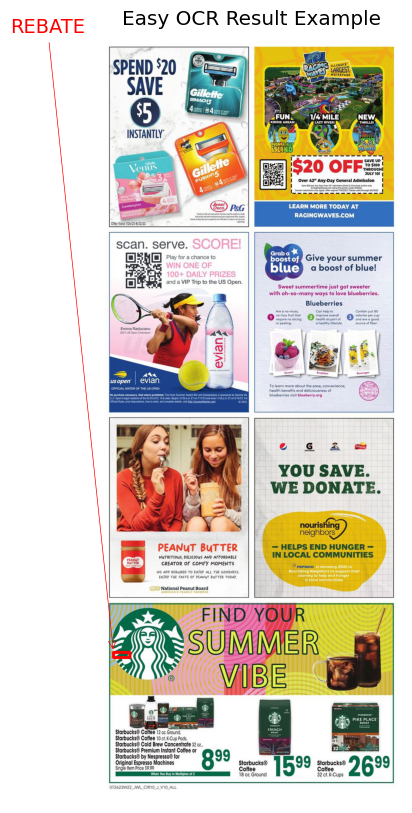

Algo has captured the target...
1
11


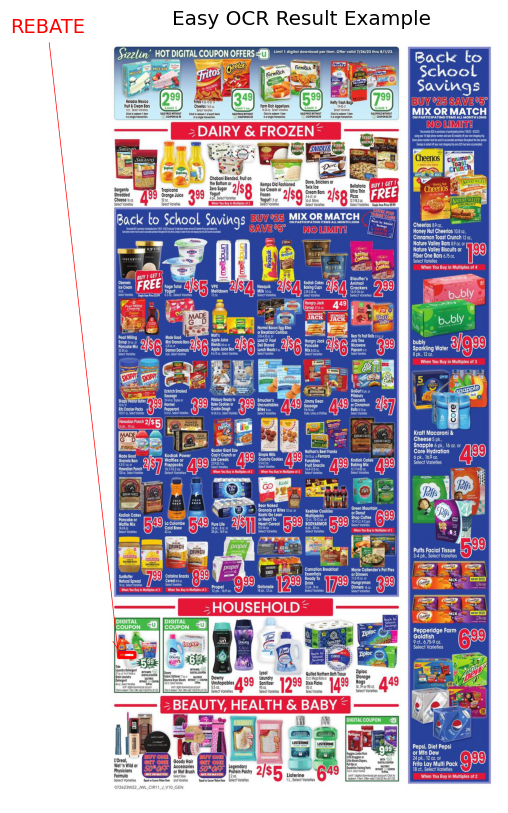

Algo has captured the target...
2
12


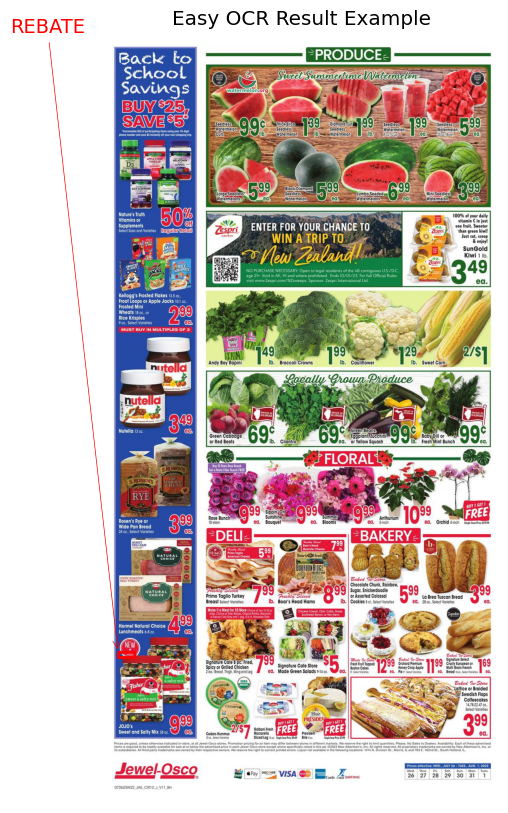

Algo has captured the target...
3
13


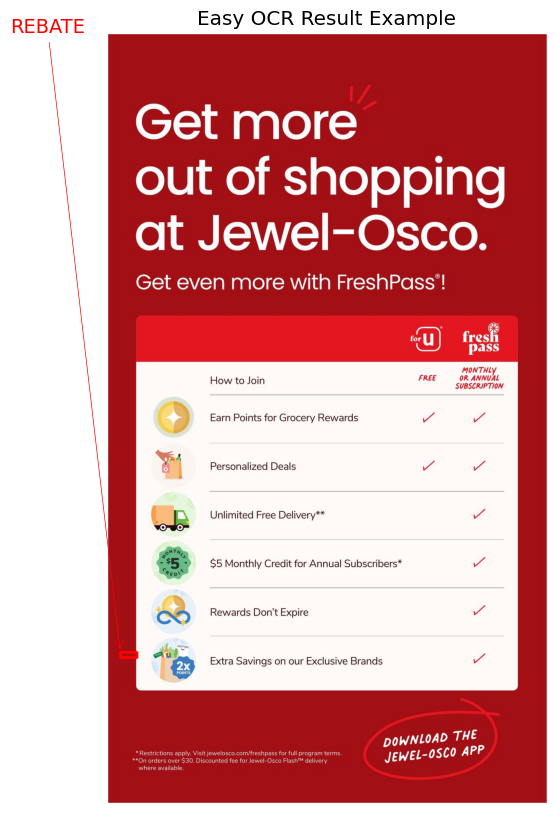

Algo has captured the target...
4
1


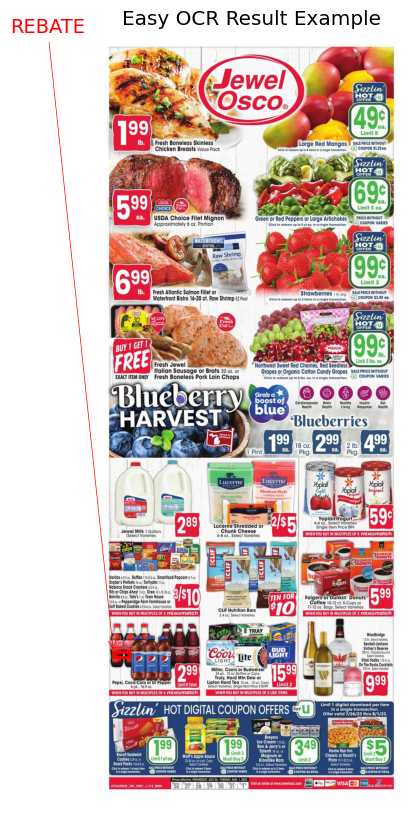

Algo has captured the target...
5
2


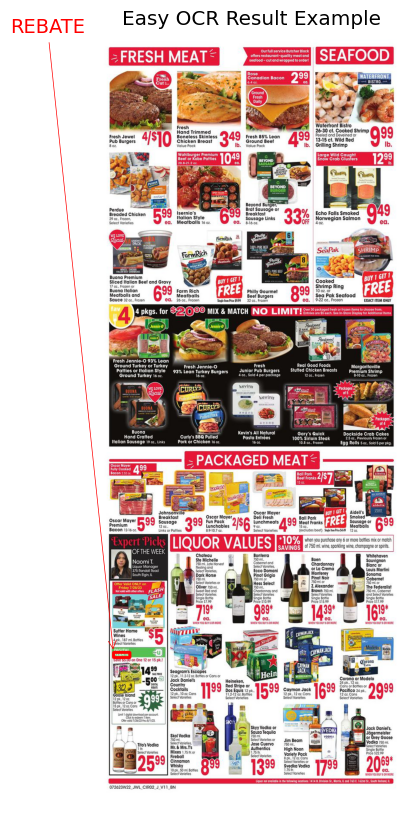

Algo has captured the target...
6
3


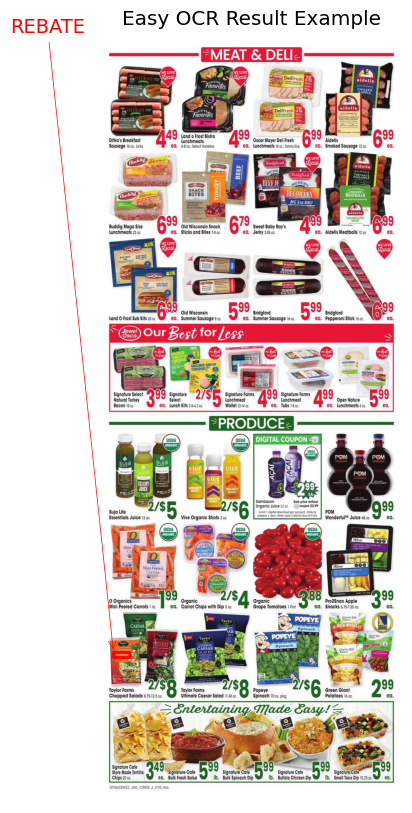

Algo has captured the target...
7
4


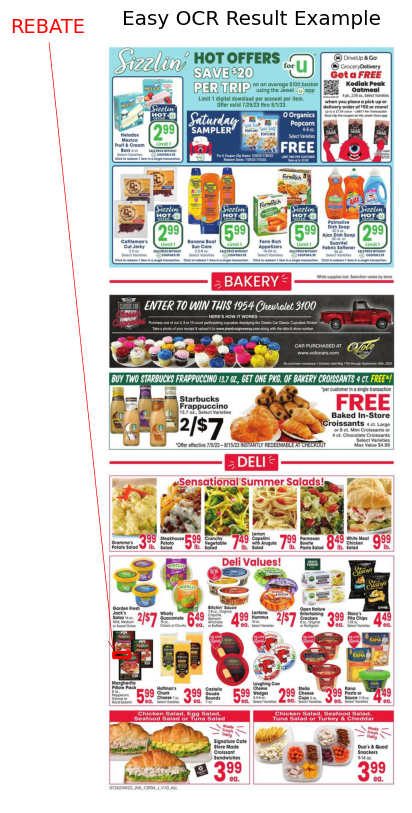

Algo has captured the target...
8
5


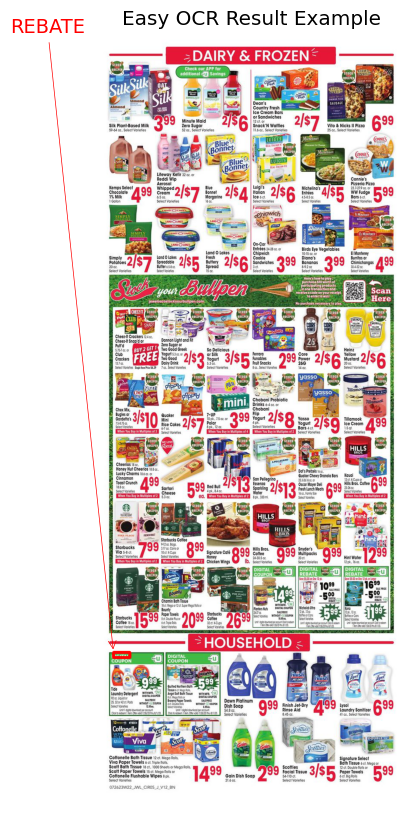

Algo has captured the target...
9
6


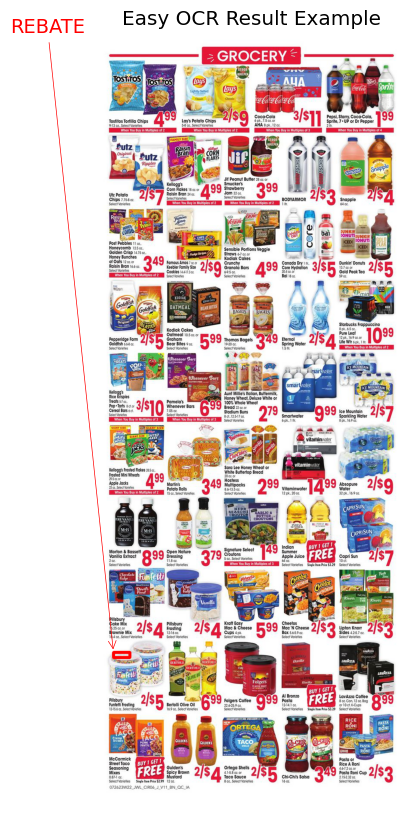

Algo has captured the target...
10
7


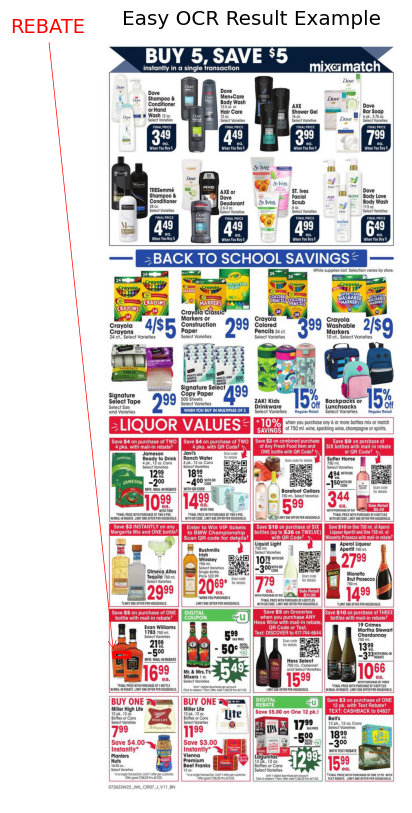

Algo has captured the target...
11
8


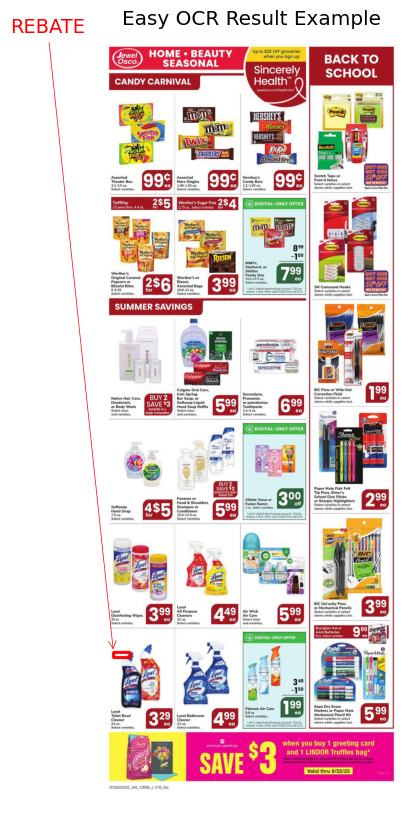

Algo has captured the target...
12
9


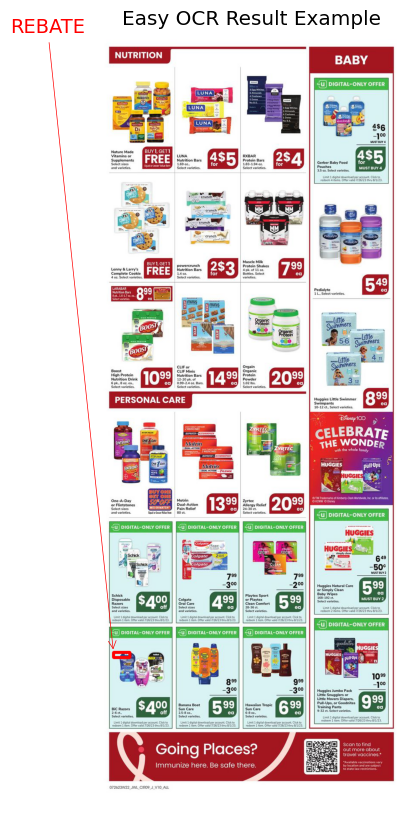

In [12]:
# df_repor = []
for index, img_path in enumerate(image_files):
    if not df123[index].empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        print(index)

        ##Getting the page number
        img_id = img_path.split('\\')[-1]
        page_number = re.search(r'page_(\d+)', img_id).group(1)
        print(page_number)
        plot_compare(img_path, df123[index], page_number)

        # filtered_df, grouped_df = merge_logic(dfs[index])
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index {index} as the DataFrame is empty.")
    # print(index, val)

### Goal 2

### Merger close proximity strings

In [ ]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2

    dist = abs(center1_x - center2_x)

    return dist

def merge_logic(df):

    grouped_text = []
    grouped_indices = []
    grouped_conf = []
    group_threshold =20

    for idx, row in df.iterrows():

        index_track = []

        if idx in [item for sublist in grouped_indices for item in sublist]:
            continue

        text = row['text']
        conf = row['conf']
        grouped = False

        if idx == (df.shape[0]-1):
            break

        for idx2, row2 in df.iterrows():
            
            if idx2 == idx or idx2 in [item for sublist in grouped_indices for item in sublist]:
                continue

            bbox1 = eval(row['bbox']) if isinstance(row['bbox'], str) else row['bbox']
            bbox2 = eval(row2['bbox']) if isinstance(row2['bbox'], str) else row2['bbox']
            
            if horizontal_distance(bbox1, bbox2) <= group_threshold:

                text += ' ' + row2['text']
                conf = max(conf, row2['conf'])

                index_track.append(idx2)
                # conf_track.append(conf)
                grouped = True

        if grouped:

            grouped_text.append(text)
            grouped_conf.append(conf)
            index_track = [idx] + index_track
            grouped_indices.append(index_track)

    grouped_data = {'text': grouped_text, 'merged_indices': grouped_indices, 'conf': grouped_conf}
    grouped_df = pd.DataFrame(grouped_data)

    return grouped_df

def merge_original_df(grouped_df, df):

    # Iterate through rows of merge_df
    for _, row in grouped_df.iterrows():
        merged_indices = row['merged_indices']
        merged_text = row['text']
        max_conf = row['conf']
        
        # Update the original DataFrame with merged data
        df.loc[merged_indices[0], 'text'] = merged_text
        df.loc[merged_indices[0], 'conf'] = max_conf
        
        # Drop the rows at merged indices
        df.drop(index=merged_indices[1:], inplace=True)

    return df


In [ ]:
df123 = dfs.copy()

In [ ]:
df_report = []
for df in df123:
    if not df.empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        print(df)
        print('Grouped......................')
        grouped_df = merge_logic(df)
        print(grouped_df)

        output = merge_original_df(grouped_df, df)
        print(output)
        df_report.append(output)
        
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index as the DataFrame is empty.")
        df_report.append(pd.DataFrame())

### Preparing enrichment table

In [ ]:
# Concatenate DataFrames
df_report = pd.concat(df_report)

# Reset index
df_report.reset_index(drop=True, inplace=True)

print(df_report)

#### Mapping to the desired string

In [ ]:
def map_text(text):
    words = text.lower().split()

    if len(words) == 2:
        if words[0].startswith('dig') and words[1].startswith('coup'):
            return 'DIGITAL COUPON'
        elif words[0].startswith('dig') and words[1].startswith('reb'):
            return 'DIGITAL REBATE'
    elif len(words) == 1:
        if words[0].startswith('coup'):
            return 'DIGITAL COUPON'
        elif words[0].startswith('reb'):
            return 'DIGITAL REBATE'


In [ ]:
df_report_cpy = df_report.copy()

In [ ]:
# Apply the mapping function to 'text' column
df_report_cpy['text'] = df_report_cpy['text'].apply(map_text)

In [ ]:
# Create a DataFrame with page_number and text columns
page_counts = df_report_cpy.groupby(['page_number', 'text']).size().reset_index(name='count')
# page_counts.drop(columns = ['text'], inplace=True)
page_counts

In [ ]:
pivot_df = page_counts.pivot(index='page_number', columns='text', values='count').fillna(0).reset_index()

In [ ]:
pivot_df.reset_index(level=0, inplace=True)
pivot_df

In [ ]:
page = list(pivot_df['page_number'].values)

DIGITAL_COUPON = list(pivot_df['DIGITAL COUPON'].values)

DIGITAL_REBATE = list(pivot_df['DIGITAL REBATE'].values)

# Create a DataFrame from the arrays
data = {'page': page, 'DIGITAL COUPON': DIGITAL_COUPON, 'DIGITAL REBATE': DIGITAL_REBATE}
df = pd.DataFrame(data)

In [ ]:
# Add missing numbers to columns and fill other columns with 0
numbers  = list(range(1,14))
for number in numbers:
    if number not in df['page']:
        new_row = [number] + [0] * (df.shape[1] - 1)
        df.loc[len(df)] = new_row

df